In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import plotly.io as pio
import os

### Исходные данные

Признаки V1, ..., V28 являются результатом работы PCA, поэтому сильно заострять внимание на предварительном анализе данных мы не будем

In [2]:
df = pd.read_csv('../data/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
X = df.drop(columns=['Class'], axis=1)
y = df['Class']

Очень сильный дизбаланс классов: всего 0,17% мошенников всего в датасете. Нужно попробовать разбить датасет на выборки так, чтобы количество мошенников и там, и там было одинаково маленьким

In [4]:
y[y == 1].shape[0]/y.shape[0]

0.001727485630620034

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold

Это можно сделать с помощью `stratify=y` и `StratifiedKFold`:

In [6]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
    print(y_train_fold[y_train_fold == 1].shape[0]/y_train_fold.shape[0])
    print(y_val_fold[y_val_fold == 1].shape[0]/y_val_fold.shape[0])

0.0017248643808921893
0.001738008400373935
0.001731436433899287
0.0017248643808921893
0.001731436433899287
0.0017248643808921893


## Обучение и тюнинг

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score
import logging
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances
optuna.logging.set_verbosity(optuna.logging.WARNING)

В качестве метрики качества будем использовать Precision-Recall AUC:

In [8]:
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

Будем рассматривать метод `ExtraTreesClassifier` из `sklearn`. Он хорошо работает с дисбалансными классами, а так же у него есть параметр `class_weight`, который позволяет балансировать веса классов. Есть три варианта:
- `None`, то есть весов у классов нет;
- `balanced`, то есть вес класса пропорционален его частоте;
- `custom` (задаётся словарём), то есть мы сами задаём каждому классу его вес. 

Попробуем все три эти алгоритма и подберём оптимальные гиперпараметры, используя библиотеку `optuna`.

### class_weight = balanced

In [9]:
def objective_balanced(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', low=50, high=300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 20, 30, 40]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', low=1, high=20),
        'min_samples_split': trial.suggest_int('min_samples_split', low=2, high=20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'class_weight': 'balanced',
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_samples': trial.suggest_float('max_samples', low=0.5, high=1.0) if trial.params['bootstrap'] else None,
        'random_state': 42,
        'n_jobs': -1,
        'criterion': 'gini',
    }
    
    params = {k: v for k, v in params.items() if v is not None}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        
        model = ExtraTreesClassifier(**params)
        model.fit(X_train_fold, y_train_fold)
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        score = average_precision_score(y_val_fold, y_pred)
        scores.append(score)
    
    return np.mean(scores)

In [10]:
study_balanced = optuna.create_study(direction='maximize', study_name='balanced_weight')
study_custom = optuna.create_study(direction='maximize', study_name='custom_weight')
study_none = optuna.create_study(direction='maximize', study_name='no_weight')

In [11]:
study_balanced.optimize(objective_balanced, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
fig = plot_optimization_history(study_balanced)
os.makedirs("../results/optuna/et_balanced/", exist_ok=True)
pio.write_html(fig, "../results/optuna/et_balanced/optimization_history_et_balanced.html")
fig.show()

In [13]:
fig = plot_param_importances(study_balanced)
pio.write_html(fig, "../results/optuna/et_balanced/param_importances_et_balanced.html")
fig.show()

In [14]:
best_params_balanced = study_balanced.best_params
best_params_balanced

{'n_estimators': 291,
 'max_depth': 40,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'max_features': 0.7,
 'bootstrap': False}

In [10]:
complete_params = {
    **best_params_balanced,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1,
    'criterion': 'gini',
    'verbose': 0,
    'max_samples': None,
}

In [11]:
model_balanced = ExtraTreesClassifier(**complete_params)
model_balanced.fit(X_trainval, y_trainval)
y_test_pred = model_balanced.predict_proba(X_test)[:, 1]
test_pr_auc_balanced = average_precision_score(y_test, y_test_pred)
test_pr_auc_balanced

0.8788076705328343

In [12]:
os.makedirs("../models/et/", exist_ok=True)
joblib.dump(model_balanced, "../models/et/model_et_balanced.pkl") # Save model
# model_balanced = joblib.load("../models/et/model_et_balanced.pkl") # Load model

['../models/et/model_et_balanced.pkl']

### class_weight = {0: 1, 1: fraud_weight}

In [18]:
def objective_custom_weight(trial):
    fraud_weight = trial.suggest_float('fraud_weight', low=10, high=500, log=True)
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', low=50, high=300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 20, 30, 40]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', low=1, high=20),
        'min_samples_split': trial.suggest_int('min_samples_split', low=2, high=20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'class_weight': {0: 1, 1: fraud_weight},
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_samples': trial.suggest_float('max_samples', low=0.5, high=1.0) if trial.params['bootstrap'] else None,
        'random_state': 42,
        'n_jobs': -1,
        'criterion': 'gini',
    }
    
    params = {k: v for k, v in params.items() if v is not None}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        
        model = ExtraTreesClassifier(**params)
        model.fit(X_train_fold, y_train_fold)
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        score = average_precision_score(y_val_fold, y_pred)
        scores.append(score)
    
    return np.mean(scores)

In [19]:
study_custom.optimize(objective_custom_weight, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [20]:
fig = plot_optimization_history(study_custom)
os.makedirs("../results/optuna/et_custom/", exist_ok=True)
pio.write_html(fig, "../results/optuna/et_custom/optimization_history_et_custom.html")
fig.show()

In [21]:
fig = plot_param_importances(study_custom)
pio.write_html(fig, "../results/optuna/et_custom/param_importances_et_custom.html")
fig.show()

In [22]:
best_params_custom = study_custom.best_params
best_params_custom

{'fraud_weight': 16.856023670761537,
 'n_estimators': 219,
 'max_depth': 40,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'max_features': 0.5,
 'bootstrap': False}

In [17]:
fraud_weight = best_params_custom['fraud_weight']
class_weight_dict = {0: 1, 1: fraud_weight}
complete_params_custom = {
    'n_estimators': best_params_custom['n_estimators'],
    'max_depth': best_params_custom['max_depth'],
    'min_samples_leaf': best_params_custom['min_samples_leaf'],
    'min_samples_split': best_params_custom['min_samples_split'],
    'max_features': best_params_custom['max_features'],
    'bootstrap': best_params_custom['bootstrap'],
    'class_weight': class_weight_dict,
    'random_state': 42,
    'n_jobs': -1,
    'criterion': 'gini',
    'verbose': 0,
}

In [18]:
model_custom = ExtraTreesClassifier(**complete_params_custom)
model_custom.fit(X_trainval, y_trainval)
y_test_pred = model_custom.predict_proba(X_test)[:, 1]
test_pr_auc_custom = average_precision_score(y_test, y_test_pred)
test_pr_auc_custom

0.8791484677198578

In [19]:
joblib.dump(model_custom, "../models/et/model_et_custom.pkl") # Save model
# model_custom = joblib.load("../models/et/model_et_custom.pkl") # Load model

['../models/et/model_et_custom.pkl']

### class_weight = None

In [26]:
def objective_no_weight(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', low=50, high=300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 20, 30, 40, 50, 60]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', low=1, high=20),
        'min_samples_split': trial.suggest_int('min_samples_split', low=2, high=20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7]),
        'class_weight': None,
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_samples': trial.suggest_float('max_samples', low=0.5, high=1.0) if trial.params['bootstrap'] else None,
        'random_state': 42,
        'n_jobs': -1,
        'criterion': 'gini',
    }
    
    params = {k: v for k, v in params.items() if v is not None}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        
        model = ExtraTreesClassifier(**params)
        model.fit(X_train_fold, y_train_fold)
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        score = average_precision_score(y_val_fold, y_pred)
        scores.append(score)
    
    return np.mean(scores)

In [27]:
study_none.optimize(objective_no_weight, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [28]:
fig = plot_optimization_history(study_none)
os.makedirs("../results/optuna/et_none/", exist_ok=True)
pio.write_html(fig, "../results/optuna/et_none/optimization_history_et_none.html")
fig.show()

In [29]:
fig = plot_param_importances(study_none)
pio.write_html(fig, "../results/optuna/et_none/param_importances_et_none.html")
fig.show()

In [30]:
best_params_none = study_none.best_params
best_params_none

{'n_estimators': 299,
 'max_depth': 60,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'max_features': 0.5,
 'bootstrap': False}

In [21]:
complete_params_none = {
    'n_estimators': best_params_none['n_estimators'],
    'max_depth': best_params_none['max_depth'],
    'min_samples_leaf': best_params_none['min_samples_leaf'],
    'min_samples_split': best_params_none['min_samples_split'],
    'max_features': best_params_none['max_features'],
    'bootstrap': best_params_none['bootstrap'],
    'class_weight': None,
    'random_state': 42,
    'n_jobs': -1,
    'criterion': 'gini',
    'verbose': 0,
}

In [22]:
model_none = ExtraTreesClassifier(**complete_params_none)
model_none.fit(X_trainval, y_trainval)
y_test_pred = model_none.predict_proba(X_test)[:, 1]
test_pr_auc_none = average_precision_score(y_test, y_test_pred)
test_pr_auc_none

0.8739039864807924

In [23]:
joblib.dump(model_none, "../models/et/model_et_none.pkl") # Save model
# model_none = joblib.load("../models/et/model_et_none.pkl") # Load model

['../models/et/model_et_none.pkl']

## LightGBM

In [24]:
import lightgbm as lgb

In [25]:
def objective(trial):
    params = {
        'device': 'gpu',
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', low=30, high=120),
        'learning_rate': trial.suggest_float('learning_rate', low=0.001, high=0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', low=0.5, high=1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', low=0.5, high=1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', low=1, high=10),
        'min_child_samples': trial.suggest_int('min_child_samples', low=50, high=500),
        'reg_alpha': trial.suggest_float('reg_alpha', low=1e-8, high=1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', low=1e-8, high=1.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', low=100, high=1000),
        'verbose': -1,
        'random_state': 42,
        'n_jobs': 1
    }
    
    scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        X_train_fold, X_val_fold = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        scores.append(average_precision_score(y_val_fold, y_pred))
    
    return np.mean(scores)

In [26]:
study = optuna.create_study(direction='maximize', study_name='lightgbm')
study.optimize(objective, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [27]:
fig = plot_optimization_history(study)
os.makedirs("../results/optuna/lightgbm/", exist_ok=True)
pio.write_html(fig, "../results/optuna/lightgbm/optimization_history_lightgbm.html")
fig.show()

In [28]:
fig = plot_param_importances(study)
pio.write_html(fig, "../results/optuna/lightgbm/param_importances_lightgbm.html")
fig.show()

In [29]:
best_params_lgbm = study.best_params
best_params_lgbm

{'num_leaves': 110,
 'learning_rate': 0.0013749452193734175,
 'feature_fraction': 0.8779319183791089,
 'bagging_fraction': 0.9715522760759239,
 'bagging_freq': 1,
 'min_child_samples': 95,
 'reg_alpha': 9.216650187940063e-08,
 'reg_lambda': 3.987820629535797e-07,
 'scale_pos_weight': 251.1896440020223}

In [30]:
best_params_lgbm.update({
    'device': 'gpu',
    'objective': 'binary',
    'metric': 'average_precision',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'random_state': 42,
    'n_jobs': 1,
})

In [31]:
lgbm_model = lgb.LGBMClassifier(**best_params_lgbm)
lgbm_model.fit(X_trainval, y_trainval)
y_test_pred = lgbm_model.predict_proba(X_test)[:, 1]
test_pr_auc_lgbm = average_precision_score(y_test, y_test_pred)
test_pr_auc_lgbm

0.8250941947316781

In [32]:
os.makedirs("../models/lgbm/", exist_ok=True)
lgbm_model.booster_.save_model("../models/lgbm/model_lgbm.json")

## Визуализация

### Сравнение алгоритмов по PR-AUC

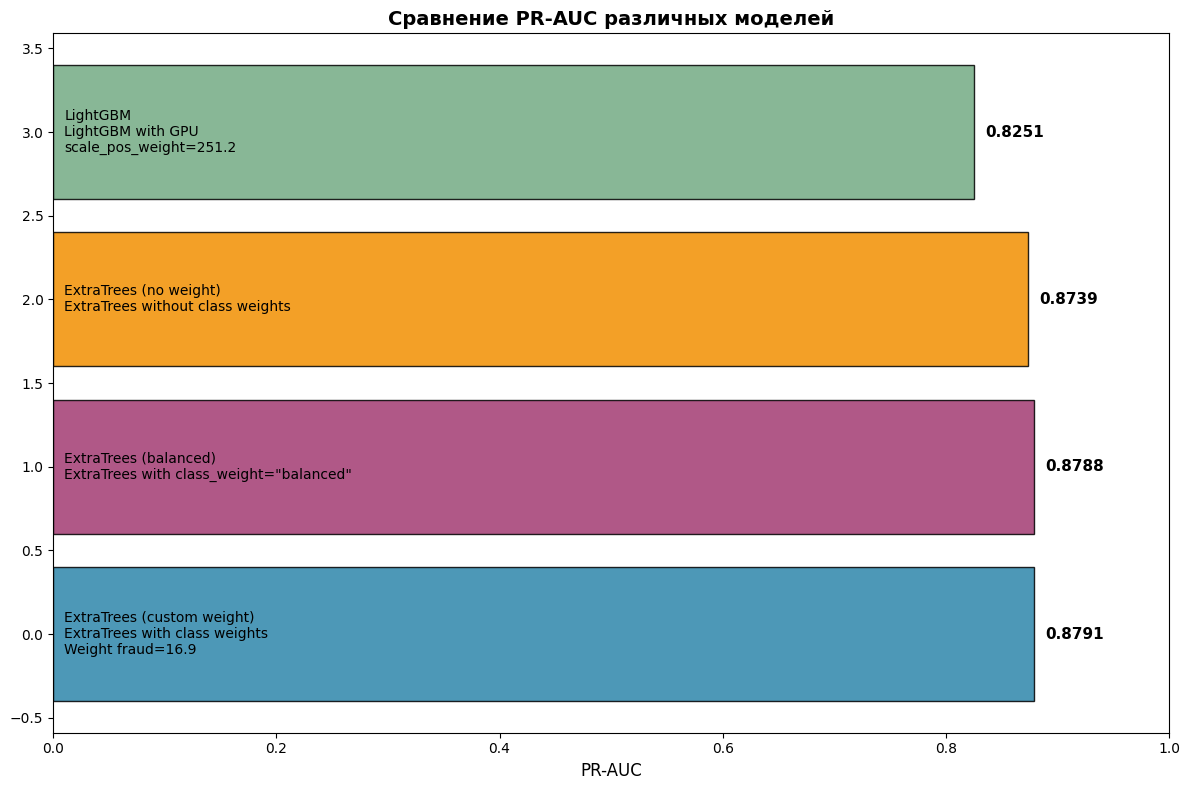

In [36]:
metrics_data = {
    'model': ['LightGBM', 'ExtraTrees (no weight)', 
               'ExtraTrees (custom weight)', 'ExtraTrees (balanced)'],
    'PR-AUC': [test_pr_auc_lgbm, test_pr_auc_none, 
               test_pr_auc_custom, test_pr_auc_balanced],
    'trivia': [
        f'LightGBM with GPU\nscale_pos_weight={best_params_lgbm['scale_pos_weight']:.1f}',
        f'ExtraTrees without class weights',
        f'ExtraTrees with class weights \nWeight fraud={best_params_custom.get("fraud_weight", 0):.1f}',
        f'ExtraTrees with class_weight="balanced"'
    ]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.sort_values('PR-AUC', ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(metrics_df)), metrics_df['PR-AUC'], 
                color=['#2E86AB', '#A23B72', '#F18F01', '#73AB84'], 
                alpha=0.85, edgecolor='black')
for i, (bar, pr_auc) in enumerate(zip(bars, metrics_df['PR-AUC'])):
    plt.text(pr_auc + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{pr_auc:.4f}', va='center', fontsize=11, fontweight='bold')
    model_name = metrics_df.iloc[i]['model']
    trivia = metrics_df.iloc[i]['trivia']
    plt.text(0.01, bar.get_y() + bar.get_height()/2, 
             f'{model_name}\n{trivia}', 
             va='center', ha='left', fontsize=10)

plt.xlabel('PR-AUC', fontsize=12)
plt.title('Сравнение PR-AUC различных моделей', fontsize=14, fontweight='bold')
plt.xlim(0, 1.0)
plt.tight_layout()
os.makedirs("../results/metric_plots/", exist_ok=True)
plt.savefig('../results/metric_plots/pr_auc_model_compare.png', dpi=300, bbox_inches='tight')
plt.show()

Как мы видим на графике, `ExtraTreesClassifier` оверперформит `LightGBM`. При этом, хоть добавление веса классам даёт улучшение метрики PR-AUC, оно всё равно является незначительным.

### Построение лучшей PR-AUC кривой

In [61]:
from sklearn.metrics import precision_recall_curve, auc

In [62]:
y_test_pred_proba = model_custom.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall, precision) # ~ average_precision_score

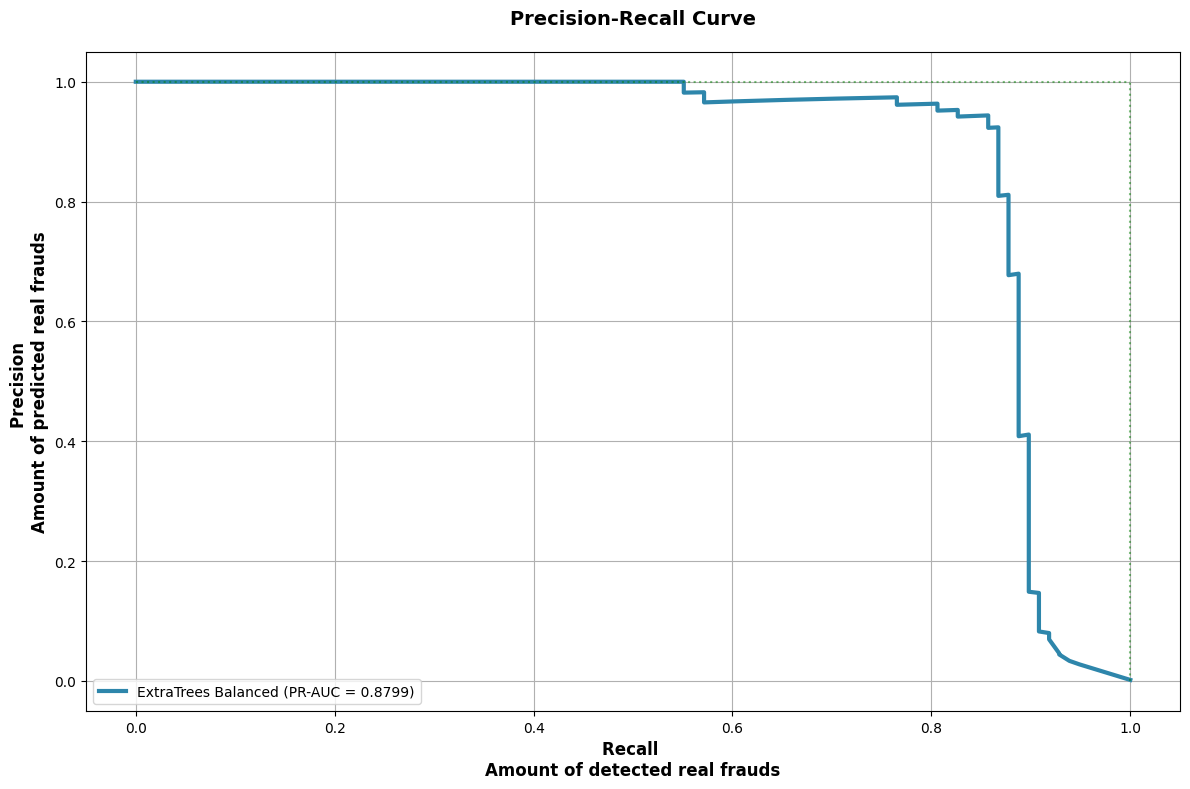

In [63]:
plt.figure(figsize=(12, 8))

plt.plot(recall, precision, linewidth=3, color='#2E86AB', 
         label=f'ExtraTrees Balanced (PR-AUC = {pr_auc:.4f})')
#baseline = y_test.mean()
#plt.axhline(y=baseline, color='red', linestyle='--', linewidth=2, label=f'Baseline = {baseline:.4f}')
plt.plot([0, 1], [1, 1], color='green', linestyle=':', linewidth=1.5, alpha=0.5)
plt.plot([1, 1], [0, 1], color='green', linestyle=':', linewidth=1.5, alpha=0.5)

plt.xlabel('Recall \nAmount of detected real frauds', fontsize=12, fontweight='bold')
plt.ylabel('Precision \nAmount of predicted real frauds', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
plt.grid(True)
plt.legend(loc='lower left', fontsize=10)
plt.tight_layout()
plt.savefig('../results/metric_plots/pr_auc_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

## Поиск оптимального порога

Теперь нужно найти оптимальный порог, чтоб мы могли поймать как можно больше мошенников, но при этом уменьшить количество ложных срабатываний.

### Высокий recall

Найдём ближайшее значение recall к значению 0.9, рассмотрим эту точку:

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
target_recall_idx = np.argmin(np.abs(recall[:-1] - 0.9))
target_threshold = thresholds[target_recall_idx]
target_threshold # Порог в этом случае

np.float64(0.013214306387144754)

In [66]:
target_recall = recall[target_recall_idx]
target_recall # пойманный recall

np.float64(0.8979591836734694)

In [67]:
target_precision = precision[target_recall_idx]
target_precision # precision в этом случае

np.float64(0.14890016920473773)

Посмотрим на матрицу ошибок в этом случае

In [68]:
y_pred_at_threshold = (y_test_pred_proba >= target_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_at_threshold).ravel()
print(f"True Negatives (TN):  {tn} - correct normal;")
print(f"False Positives (FP): {fp} - incorrect normal;")
print(f"False Negatives (FN): {fn} - missed frauds;")
print(f"True Positives (TP):  {tp} - caught frauds.")

True Negatives (TN):  56361 - correct normal;
False Positives (FP): 503 - incorrect normal;
False Negatives (FN): 10 - missed frauds;
True Positives (TP):  88 - caught frauds.


В этом случае, мы правильно определяем ~90% мошенников, но в этом случае у нас много ложных срабатываний на немошенниках.

### Максимизация F1-меры

In [69]:
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-10)
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_threshold

np.float64(0.41991230037640004)

In [70]:
best_precision = precision[best_f1_idx]
best_precision

np.float64(0.9438202247191011)

In [71]:
best_recall = recall[best_f1_idx]
best_recall

np.float64(0.8571428571428571)

In [72]:
y_pred_at_threshold = (y_test_pred_proba >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_at_threshold).ravel()
print(f"True Negatives (TN):  {tn} - correct normal;")
print(f"False Positives (FP): {fp} - incorrect normal;")
print(f"False Negatives (FN): {fn} - missed frauds;")
print(f"True Positives (TP):  {tp} - caught frauds")

True Negatives (TN):  56859 - correct normal;
False Positives (FP): 5 - incorrect normal;
False Negatives (FN): 14 - missed frauds;
True Positives (TP):  84 - caught frauds


Наша модель "ловит" 85% мошенников. \
Если мы предсказываем, что транзакция будет подозрительной, то мы будем правы в 94% случаев.

In [73]:
best_threshold # (One of) the best threshold(s) for our task
best_threshold

np.float64(0.41991230037640004)